In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

In [2]:
appliance= 'air'
start = 0
end = 2

In [3]:
import tensorflow_probability.substrates.jax as tfp
import jax
import optax
from functools import partial
import seaborn as sns
import tensorflow as tf
dist = tfp.distributions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import random
from dataloader import *
from utilities import *
from model import *
from retrain_fun import *
random.seed(0)
np.random.seed(0)
jax.random.PRNGKey(0)
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC']='1'


2023-06-12 23:08:58.431192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
data_aggregated, houses = data_preprocess(only_positive=True)

In [5]:
train_list_furnace = [[2361, 7719, 9019, 2335, 7951]]
test_list_furnace = [[4373, 7901, 3456, 3538, 2818]]
pool_list_furnace=[]
for i in range(len(train_list_furnace)):
    pool = [j for j in houses if j not in train_list_furnace[i]+test_list_furnace[i]] #[1,2,3,3]
    pool_list_furnace.append(pool) #pool list = [[1,2,3,3]]

train_list_clotheswasher = [[2361, 7719, 9019, 2335, 7951]]
test_list_clotheswasher = [[4373, 7901, 3456, 3538, 2818]]
pool_list_clotheswasher=[]
for i in range(len(train_list_clotheswasher)):
    pool = [j for j in houses if j not in train_list_clotheswasher[i]+test_list_clotheswasher[i]]
    pool_list_clotheswasher.append(pool)

train_list_dishwasher = [[2361, 7719, 9019, 2335, 7951]]
test_list_dishwasher = [[4373, 7901, 3456, 3538, 2818]]
pool_list_dishwasher=[]
for i in range(len(train_list_dishwasher)):
    pool = [j for j in houses if j not in train_list_dishwasher[i]+test_list_dishwasher[i]]
    pool_list_dishwasher.append(pool)

train_list_refrigerator =  [[2361, 7719, 9019, 2335, 7951]]
test_list_refrigerator = [[4373, 7901, 3456, 3538, 2818]]
pool_list_refrigerator=[]
for i in range(len(train_list_refrigerator)):
    pool = [j for j in houses if j not in train_list_refrigerator[i]+test_list_refrigerator[i]]
    pool_list_refrigerator.append(pool)


train_list_air = [[2361, 7719, 9019, 2335, 7951]]
test_list_air = [[4373, 7901, 3456, 3538, 2818]]
pool_list_air=[]
for i in range(len(train_list_air)):
    pool = [j for j in houses if j not in train_list_air[i]+test_list_air[i]]
    pool_list_air.append(pool)


In [6]:
all_appliance_train_lists = {
    'air':train_list_air, 'furnace':train_list_furnace,'dishwasher':train_list_dishwasher, 'refrigerator':train_list_refrigerator, 'clotheswasher':train_list_clotheswasher
}
all_appliance_test_lists = {
    'air':test_list_air, 'furnace':test_list_furnace,'dishwasher':test_list_dishwasher, 'refrigerator':test_list_refrigerator, 'clotheswasher':test_list_clotheswasher
}
all_appliance_pool_lists = {
    'air':pool_list_air, 'furnace':pool_list_furnace,'dishwasher':pool_list_dishwasher, 'refrigerator':pool_list_refrigerator, 'clotheswasher':pool_list_clotheswasher
}

In [7]:
random_picks = {'furnace':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]],
 'clotheswasher_og':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]],
 'clotheswasher':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]]
 , 
 'refrigerator':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]], 
 'dishwasher':[[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]], 
 'air': [[8156, 661, 7800, 8386, 8565, 5746, 9278, 7536, 1642, 9160],
 [7800, 9160, 8565, 661, 1642, 9278, 8156, 7536, 5746, 8386],
 [8565, 9160, 8386, 661, 5746, 7536, 7800, 1642, 9278, 8156],
 [7800, 7536, 661, 8386, 9278, 1642, 8565, 5746, 9160, 8156],
 [7536, 7800, 8156, 9278, 661, 5746, 8386, 8565, 9160, 1642],
 [661, 8156, 9278, 7800, 8386, 7536, 9160, 1642, 5746, 8565],
 [661, 1642, 8386, 9160, 9278, 5746, 7536, 8156, 8565, 7800],
 [7800, 9278, 1642, 5746, 7536, 8156, 9160, 8565, 8386, 661],
 [5746, 661, 9160, 8156, 9278, 8565, 7536, 8386, 1642, 7800],
 [7800, 8565, 8156, 8386, 7536, 9278, 661, 1642, 5746, 9160]]
}

STARTING FOR air, FOR ITERATIONS - 0 to 2
############################################Random iteration number#################################### : 1
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 0.0
RMSE : 840.0187 MAE  : 332.3535 NLL : 1089753.0000
I am random house id = 8156
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([3]),)
[3]
3
-------------------------------------------Iteration No:----------------------------------------- -> 0.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156]
(82890, 99)
RMSE : 842.0884 MAE  : 330.5873 NLL : 430487.6562
-------------------------------------------Iteration No:----------------------------------------- -> 0.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661]
(116959, 99)


2023-06-12 23:10:28.338225: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[116959,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[116959,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 797.6124 MAE  : 314.0331 NLL : 5.4845
-------------------------------------------Iteration No:----------------------------------------- -> 0.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 7800]
(163023, 99)


2023-06-12 23:10:48.487072: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[163023,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[163023,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:10:49.600477: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[163023,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[163023,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06

RMSE : 355.1679 MAE  : 146.1001 NLL : 4.8909
-------------------------------------------Iteration No:----------------------------------------- -> 0.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 7800 8386]
(226287, 99)


2023-06-12 23:11:15.580954: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[226287,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[226287,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:11:16.768690: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[226287,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[226287,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:

RMSE : 286.8689 MAE  : 113.8382 NLL : 4.5077
-------------------------------------------Iteration No:----------------------------------------- -> 0.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 7800 8386 8565]
(286063, 99)


2023-06-12 23:11:51.626243: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[286063,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[286063,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:11:53.135830: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[286063,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[286063,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:

RMSE : 181.3632 MAE  : 64.3727 NLL : 4.4789
-------------------------------------------Iteration No:----------------------------------------- -> 0.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 7800 8386 8565 5746]
(349033, 99)


2023-06-12 23:12:36.347508: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[349033,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[349033,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:12:38.169875: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[349033,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[349033,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:

RMSE : 202.8439 MAE  : 73.2546 NLL : 4.3782
-------------------------------------------Iteration No:----------------------------------------- -> 0.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 7800 8386 8565 5746 9278]
(416332, 99)


2023-06-12 23:13:29.331991: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[416332,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[416332,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:13:31.447115: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[416332,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[416332,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:

RMSE : 202.0380 MAE  : 71.9727 NLL : 4.2199
-------------------------------------------Iteration No:----------------------------------------- -> 0.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 7800 8386 8565 5746 9278 7536]
(490215, 99)


2023-06-12 23:14:31.962990: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[490215,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[490215,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:14:34.422816: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[490215,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[490215,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 161.9499 MAE  : 53.5662 NLL : 4.3442
-------------------------------------------Iteration No:----------------------------------------- -> 0.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 8156  661 7800 8386 8565 5746 9278 7536 1642]
(571582, 99)


2023-06-12 23:15:44.935781: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[571582,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[571582,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:15:47.886856: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[571582,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[571582,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 117.3661 MAE  : 39.6157 NLL : 4.2281
############################################Random iteration number#################################### : 2
I am pool houses picck [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
-------------------------------------------Iteration No:----------------------------------------- -> 1.0
RMSE : 840.0187 MAE  : 332.3535 NLL : 1089753.0000
I am random house id = 7800
I am pool houses [5746, 8565, 9278, 8156, 8386, 9160, 661, 1642, 7536, 7800]
(array([9]),)
[9]
9
-------------------------------------------Iteration No:----------------------------------------- -> 1.1


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800]
(82897, 99)
RMSE : 842.7358 MAE  : 331.4934 NLL : 13044.0625
-------------------------------------------Iteration No:----------------------------------------- -> 1.2


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9160]
(113762, 99)


2023-06-12 23:17:34.391821: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[113762,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[113762,50,99]{2,1,0}, f32[50,50,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 547.2720 MAE  : 227.8333 NLL : 5.0936
-------------------------------------------Iteration No:----------------------------------------- -> 1.3


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9160 8565]
(158928, 99)


2023-06-12 23:17:54.093486: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[158928,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[158928,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:17:55.167371: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[158928,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[158928,40,99]{2,1,0}, f32[50,40,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06

RMSE : 216.8294 MAE  : 85.8965 NLL : 4.8480
-------------------------------------------Iteration No:----------------------------------------- -> 1.4


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9160 8565  661]
(220206, 99)


2023-06-12 23:18:20.279910: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[220206,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[220206,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:18:21.445820: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[220206,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[220206,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:

RMSE : 209.6790 MAE  : 81.0454 NLL : 4.9212
-------------------------------------------Iteration No:----------------------------------------- -> 1.5


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9160 8565  661 1642]
(277770, 99)


2023-06-12 23:18:55.522992: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[277770,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[277770,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:18:56.940986: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[277770,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[277770,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:

RMSE : 208.8442 MAE  : 77.3485 NLL : 4.7545
-------------------------------------------Iteration No:----------------------------------------- -> 1.6


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9160 8565  661 1642 9278]
(341907, 99)


2023-06-12 23:19:38.862390: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[341907,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[341907,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:19:40.622119: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[341907,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[341907,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:

RMSE : 234.7971 MAE  : 82.7753 NLL : 4.5235
-------------------------------------------Iteration No:----------------------------------------- -> 1.7


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9160 8565  661 1642 9278 8156]
(412837, 99)


2023-06-12 23:20:31.145270: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[412837,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[412837,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:20:33.317243: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[412837,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[412837,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:

RMSE : 159.9154 MAE  : 55.6747 NLL : 4.3300
-------------------------------------------Iteration No:----------------------------------------- -> 1.8


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9160 8565  661 1642 9278 8156 7536]
(491562, 99)


2023-06-12 23:21:32.837207: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[491562,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[491562,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:21:35.321446: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[491562,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[491562,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 118.8510 MAE  : 40.9499 NLL : 4.2126
-------------------------------------------Iteration No:----------------------------------------- -> 1.9


/home/dhruv.patel/final_active/pos/retrain_fun.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_df)


Train houses are
[7719 9019 2335 2361 7951 7800 9160 8565  661 1642 9278 8156 7536 5746]
(570526, 99)


2023-06-12 23:22:44.854022: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[570526,30,99]{2,1,0}, u8[0]{0}) custom-call(f32[570526,30,106]{2,1,0}, f32[30,30,8]{2,1,0}), window={size=8}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2023-06-12 23:22:47.695569: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[570526,40,99]{2,1,0}, u8[0]{0}) custom-call(f32[570526,30,104]{2,1,0}, f32[40,30,6]{2,1,0}), window={size=6}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


RMSE : 111.5132 MAE  : 38.2284 NLL : 3.9628


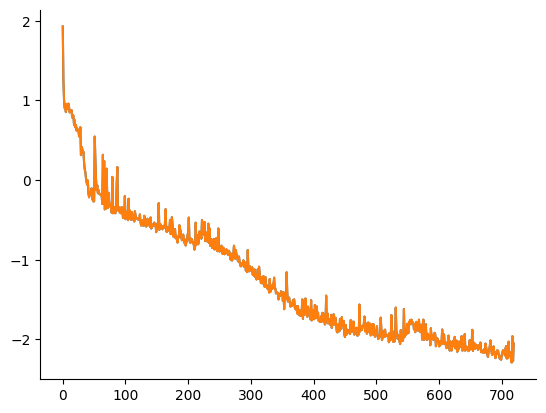

In [8]:
total_rmse=[]
houseids=[]

all_rmses = dict()
all_maes = dict() 
all_preds = dict() 

iteration_number = f'{start}_{end}_iterations'

print(f"STARTING FOR {appliance}, FOR ITERATIONS - {start} to {end}")

for i in range(start,end): #total 10 iterations

    print(f"############################################Random iteration number#################################### : {i+1}")

    train_houses = all_appliance_train_lists[appliance][0] 
    test_houses = all_appliance_test_lists[appliance][0] 
    pool_houses = all_appliance_pool_lists[appliance][0] 

    print(f"I am pool houses picck {pool_houses}")
    
    
    train = data_aggregated[data_aggregated["dataid"].isin(train_houses)] 
    test = data_aggregated[data_aggregated["dataid"].isin(test_houses)]

    all_rmses[i] = []
    all_maes[i] = []
    all_preds[i] = []
    
    houses=[]

    start= ["2018-03-01 00:00:00-06","2018-03-11 00:00:00-06","2018-03-16 00:00:00-06","2018-03-21 00:00:00-06","2018-03-26 00:00:00-06","2018-04-01 00:00:00-06", "2018-04-06 00:00:00-06", "2018-04-11 00:00:00-06", "2018-04-16 00:00:00-06", "2018-04-21 00:00:00-06"]
    end=   ["2018-03-10 23:59:00-06","2018-03-15 23:59:00-06","2018-03-20 23:59:00-06","2018-03-25 23:59:00-06","2018-03-31 23:59:00-06","2018-04-05 23:59:00-06", "2018-04-10 23:59:00-06", "2018-04-15 23:59:00-06", "2018-04-20 23:59:00-06", "2018-04-25 23:59:00-06"]
    
    for j in range(len(start)):
        
        
        print(f"-------------------------------------------Iteration No:----------------------------------------- -> {i}.{j}")

        if(j==0):
            rmsee, maes, train, test,current_pred = retrain_random(0, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

            random_house_id = random_picks[appliance][i][j]
            print(f"I am random house id = {random_house_id}")
            print(f"I am pool houses {pool_houses}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)[0]}")
            print(f"{np.where(np.array(pool_houses)==random_house_id)[0][0]}")
            random_house_index = np.where(np.array(pool_houses)==random_house_id)[0][0]  

            houses.append(random_house_id)
            pool_houses= np.delete(pool_houses, random_house_index)
            # break #REMOVE AT THE END

        elif(j==10):
            rmsee, maes, train, test,current_pred = retrain_random(random_house_id, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

        else:
            rmsee, maes, train, test,current_pred = retrain_random(random_house_id, start[j], end[j], pool_houses, train, test,appliance, data_aggregated)
            all_rmses[i].append(rmsee.item())
            all_maes[i].append(maes.item())
            all_preds[i].append(current_pred)

            random_house_id = random_picks[appliance][i][j]
            
            random_house_index = np.where(np.array(pool_houses)==random_house_id)[0][0]  
            
            houses.append(random_house_id)
            pool_houses= np.delete(pool_houses, random_house_index)
        
        
    # total_rmse.append(rmse_iter)
    houseids.append(houses)
    
    # if i not in all_rmses:
    #     all_rmses[i] = total_rmse




In [9]:
name_of_file_rmses = "30random"+"_"+str(iteration_number) + "RMSES"+".csv"
name_of_file_maes = "30random"+"_"+str(iteration_number) + "MAES"+".csv"
# name_of_file_preds = str(random)+"_"+str(iteration_number)+"PREDS"+".csv"

if not os.path.exists(f'{appliance}'):
    os.mkdir(f'{appliance}')

# Save the DataFrame to a CSV file
pd.DataFrame(all_rmses).to_csv(os.path.join(f'{appliance}', f'{name_of_file_rmses}'), index=False)
pd.DataFrame(all_maes).to_csv(os.path.join(f'{appliance}', f'{name_of_file_maes}'), index=False)
# pd.DataFrame(all_preds).to_csv(os.path.join(f'{appliance}', f'{name_of_file_preds}'), index=False)

: 